In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.rrule import rrule, MONTHLY
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output, display
import sklearn as skl
%matplotlib inline
pd.options.display.max_rows = 1000

In [2]:
#load ye olde data
AZ_reviews = pd.read_csv('AZ_review.csv')

In [3]:
#load business data
businesses = pd.read_json('dataset/yelp_academic_dataset_business.json', lines=True)

In [4]:
incl_list = ['Asian Fusion','Buffets','Caribbean','Chinese','Trinidadian','Vegetarian','Afghan','African','Arabian','Argentine','Armenian','Australian','Austrian','Bangladeshi','Basque','Bavarian','Brasseries','British','Bulgarian','Burmese','Cambodian','Cantonese','Chilean','Colombian','Cuban','Czech','Czech/Slovakian','Dominican','Donairs','Eastern European','Egyptian','Ethiopian','Falafel','Filipino','Greek','Hainan','Haitian','Hakka','Halal','Hawaiian','Honduran','Hot Pot','Iberian','Indonesian','International','Irish','Irish Pub','Izakaya','Japanese Curry','Kebab','Kosher','Laotian','Lebanese','Malaysian','Mauritius','Mediterranean','Modern European','Mongolian','Moroccan','New Mexican Cuisine','Noodles','Northern German','Pan Asian','Peruvian','Polish','Puerto Rican','Ramen','Russian','Salvadoran','Scandinavian','Scottish','Senegalese','Shanghainese','Sicilian','Singaporean','Slovakian','Soul Food','South African','Spanish','Sri Lankan','Swiss Food','Syrian','Szechuan','Teppanyaki','Traditional Norwegian','Turkish','Tuscan','Ukrainian','Uzbek','Venezuelan','Acai Bowls','American (New)','American (Traditional)','Bagels','Baguettes','Bakeries','Barbeque','Bars','Bartenders','Beach Bars','Beer','Beer Bar','Beer Garden','Beer Gardens','Beer Hall','Beer Tours','Belgian','Bistros','Brazilian','Breakfast & Brunch','Breweries','Brewpubs','Bubble Tea','Burgers','Butcher','Cafes','Cafeteria','Cajun/Creole','Canadian (New)','Candy Stores','Caterers','Champagne Bars','Cheese Shops','Cheesesteaks','Chicken Shop','Chicken Wings','Chocolatiers & Shops','Churros','Cideries','Cocktail Bars','Coffee & Tea','Coffee Roasteries','Coffeeshops','Comfort Food','Creperies','Cupcakes','Custom Cakes','Dance Clubs','Delicatessen','Delis','Desserts','Dim Sum','Diners','Distilleries','Dive Bars','Do-It-Yourself Food','Donuts','Drive-Thru Bars','Empanadas','Ethical Grocery','Ethnic Food','Ethnic Grocery','Fast Food','Fish & Chips','Fishmonger','Fondue','Food','Food Court','Food Stands','Food Trucks','French','Fruits & Veggies','Gastropubs','Gelato','German','Gluten-Free','Honey','Hong Kong Style Cafe','Hot Dogs','Hotel bar','Hungarian','Ice Cream & Frozen Yogurt','Imported Food','Indian','International Grocery','Italian','Japanese','Japanese Sweets','Juice Bars & Smoothies','Karaoke','Kombucha','Korean','Latin American','Live/Raw Food','Local Flavor','Lounges','Macarons','Mexican','Middle Eastern','Milkshake Bars','Minho','Olive Oil','Organic Stores','Pakistani','Palatine','Pasta Shops','Patisserie/Cake Shop','Persian/Iranian','Pita','Pizza','Poke','Pop-Up Restaurants','Popcorn Shops','Poutineries','Pretzels','Pub Food','Pubs','Restaurants','Rotisserie Chicken','Salad','Sandwiches','Seafood','Serbo Croatian','Shaved Ice','Shaved Snow','Smokehouse','Soba','Soup','Southern','Speakeasies','Specialty Food','Sports Bars','Steakhouses','Street Vendors','Sugar Shacks','Supper Clubs','Sushi Bars','Tacos','Taiwanese','Tapas Bars','Tapas/Small Plates','Tea Rooms','Tempura','Thai','Themed Cafes','Tiki Bars','Tonkatsu','Udon','Vegan','Vietnamese','Waffles','Whiskey Bars','Wine & Spirits','Wine Bars','Wraps']

In [5]:
res_filter = pd.Series.from_csv('res_filter.csv')
#res_filter = (AZ_reviews['categories'].str.contains('There is absolutely no way this string is contained'))
#for i, word in enumerate(incl_list):
#    clear_output(wait=True)
#    print('{:2.2f}% \t'.format(100*i/len(incl_list))+word)
#    res_filter = (res_filter | AZ_reviews['categories'].str.contains(word))
#res_filter.to_csv('res_filter.csv')


In [6]:
AZ_reviews_nona = AZ_reviews.dropna()

AZ_reviews_res = AZ_reviews_nona[res_filter]
AZ_reviews_biz = AZ_reviews_res.merge(businesses, on='business_id')

/home/ci411/.conda/envs/py3.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
AZ_final  = AZ_reviews_biz[['date', 'business_id','user_id', 'name_x', 'cool', 'funny','useful','review_id', 'stars_x', 'categories_x','review_count', 'stars_y']]
AZ_final = AZ_final.rename(index=str, columns={'name_x':'name', 'stars_x':'stars_review','stars_y':'stars_avg', 'categories_x':'categories'})

In [8]:
#AZ_final.to_csv('AZ_cleaned_business.csv')

In [9]:
#copied functions from trendiness measure

#convert a dataframe with 'date' element to be indexed along datetime objects
def to_datetime(review_df):
    return review_df.assign(datetime = pd.to_datetime(review_df['date'])).drop(labels=['date'], axis = 'columns').set_index('datetime').sort_index()

#return a list of categories for some dataset (all rows)
def get_categories(review_df):
    listed_cats = review_df['categories'].str.split(', ').dropna()
    flat_list = [item for sublist in listed_cats.values for item in sublist]
    return flat_list

#return a list of categories for a specific business (takes either a single row or full dataframe witha businessid)
def get_categories_business(business_df, business_id = None):
    if business_id!=None:
        categories = business_df[business_df['business_id'] == business_id].iloc[0]['categories']
    else:
        categories = business_df['categories']
    listed_cats = categories.split(', ')
    return listed_cats

#finds the N most popular categories for a given year and month
def top_categories_date(reviews, year, month, N=15, stopwords = []):
    if type(reviews.index[0]) == pd._libs.tslib.Timestamp:
        review_dt = reviews
    else:
        review_dt = to_datetime(reviews)
    time_filter = ((AZ_reviews_datetimed.index.year == year) & (AZ_reviews_datetimed.index.month == month))
    time_reviews = review_dt[time_filter]
    flat_list = get_categories(time_reviews)
    counted_categories = Counter(flat_list)
    sorted_categories = list(OrderedDict(values.most_common()).keys())
    for word in stopwords:
        if(word in sorted_categories):
            sorted_categories.remove(word)
    return sorted_categories[:N]

#computes number of categories in commmon with a business and a given month
def trendiness_measure(review_df, year, month, business_id, N = 15):
    business_cats = get_categories_business(review_df, business_id = business_id)
    trendiness_cats = top_categories_date(review_df, year, month, N=N)
    return len(set(business_cats) & set(trendiness_cats))


In [10]:
AZ_reviews_dt = to_datetime(AZ_final)
AZ_businesses_grouped = AZ_reviews_dt.groupby([AZ_reviews_dt['business_id'], AZ_reviews_dt.index.year.rename('year'), AZ_reviews_dt.index.month.rename('month')])

In [11]:
AZ_final.columns

Index(['date', 'business_id', 'user_id', 'name', 'cool', 'funny', 'useful',
       'review_id', 'stars_review', 'categories', 'review_count', 'stars_avg'],
      dtype='object')

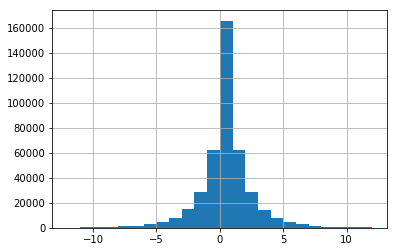

0.029703254237774205


In [12]:
max_bin = 12
rev_per_month = AZ_businesses_grouped['name'].count()
(-rev_per_month.diff(periods=-1)).hist(bins = np.linspace(-max_bin,max_bin,(max_bin*2)+1))
plt.show()

print(rev_per_month[-rev_per_month.diff(periods=-1)>=5].shape[0]/rev_per_month.shape[0])

growth_per_month = -rev_per_month.diff(periods=-1).fillna(0)

def get_growth(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    growth = growth_per_month[bid][date.year][date.month]
    #clear_output(wait=True)
    display(timestamp)
    return growth

#AZ_reviews_mg = AZ_reviews_dt.apply(lambda row: get_growth(row['business_id'], row.name), axis=1)
AZ_reviews_mg = to_datetime(pd.read_csv('monthly_growth.csv')).drop(['Unnamed: 0'], axis=1)

In [13]:
def get_percent_reviews(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    revs = rev_per_month[bid][date.year][date.month]
    r_count = rev_per_month[bid].cumsum()[date.year][date.month]
    print(timestamp)
    rev_percent = revs/r_count
    return rev_percent

In [14]:
#AZ_reviews_percent = AZ_reviews_dt.apply(lambda row: get_percent_reviews(row['business_id'], row.name), axis=1)
#clear_output(wait=False)
#AZ_reviews_percent_df = AZ_reviews_percent.to_frame()
#AZ_reviews_percent_df.columns = ['percent_reviews']
#AZ_reviews_percent_df.to_csv('percent_reviews.csv')
AZ_reviews_percent = to_datetime(pd.read_csv('percent_reviews.csv').rename(index=str, columns={'datetime':'date'}))

In [15]:
top_categories=to_datetime(pd.read_csv('trends.csv').rename(index=str, columns={'Unnamed: 0':'date'}))

#restructured trendiness measure to work nicely in a loop using the top_categories dataframe
def trendiness_measure_apply(categories, timestamp):
    if type(categories)==float:
        return 0
    business_cats = categories.split(', ')
    date = datetime.date(timestamp.year, timestamp.month, 1)
    trendiness_cats = top_categories.loc[date]['top_categories'].split(', ')
    result = len(set(business_cats) & set(trendiness_cats))
    clear_output(wait=False)
    print(timestamp)
    return result
#AZ_trendiness = AZ_reviews_dt.apply(lambda row: trendiness_measure_apply(row['categories'], row.name), axis=1)
clear_output(wait=False)


AZ_trendiness = to_datetime(pd.read_csv('trendiness_2.csv').drop('Unnamed: 0',1))
#AZ_trendiness.to_csv('trendiness_2.csv')


In [ ]:
avg_stars_per_month = AZ_businesses_grouped['stars_review'].mean()
#pulls from LAST month to prevent leakage
stars_growth_per_month = -avg_stars_per_month.diff().fillna(0)

def get_star_growth(bid, timestamp):
    date = datetime.date(timestamp.year, timestamp.month, 1)
    growth = stars_growth_per_month[bid][date.year][date.month]
    #clear_output(wait=True)
    print(date)
    return growth

AZ_reviews_sg = AZ_reviews_dt.apply(lambda row: get_star_growth(row['business_id'], row.name), axis=1)
clear_output(wait=False)
AZ_reviews_sg_df = AZ_reviews_sg.to_frame()
AZ_reviews_sg_df.columns = ['star_growth']
AZ_reviews_sg_df.to_csv('star_growth.csv')
#AZ_reviews_sg = to_datetime(pd.read_csv('star_growth.csv').rename(index=str, columns={'datetime':'date'}))


In [ ]:
AZ_reviews_sg

In [ ]:
AZ_reviews_dt['trendiness'] = AZ_trendiness
AZ_reviews_dt['monthly_growth'] = AZ_reviews_mg
AZ_reviews_dt['percent_reviews'] = AZ_reviews_percent
AZ_reviews_dt['star_growth'] = AZ_reviews_sg

In [ ]:
AZ_reviews_dt.describe()

In [ ]:
AZ_reviews_dt['high_growth'] = (AZ_reviews_dt['monthly_growth']>3)

In [ ]:
from sklearn.model_selection import train_test_split
X = AZ_reviews_dt.drop(['high_growth', 'monthly_growth', 'categories', 'business_id', 'user_id', 'name', 'review_id'],1)
X = AZ_reviews_dt[['trendiness', 'percent_reviews', 'star_growth']]
Y = AZ_reviews_dt['high_growth']
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

print("Training Decision Tree...")
dtc = DecisionTreeClassifier()
dtc.fit(Xtr, Ytr)

print("Training Logistic Regression...")
lrc = LogisticRegression()
lrc.fit(Xtr, Ytr)

#print("Training SVM...")
#sv_c = SVC(probability=True)
#sv_c.fit(Xtr, Ytr)

print("Training Bernolli Naive Bayes...")
nbc = BernoulliNB()
nbc.fit(Xtr, Ytr)

print("Decision Tree mean accuracy: {:2.4f})".format(dtc.score(Xte,Yte)))
print("Log-Reg mean accuracy: {:2.4f})".format(lrc.score(Xte,Yte)))
#print(sv_c.score(Xte,Yte))
print("Naïve Bayes mean accuracy: {:2.4f})".format(nbc.score(Xte,Yte)))
print('Base accuracy: {:2.4f}'.format(1-Yte.sum()/Yte.count()))

In [ ]:
print(Xtr.columns)
print(dtc.feature_importances_)

In [ ]:
from sklearn.metrics import roc_curve, auc

models = [dtc, lrc, nbc]
models_l = ['dtc', 'lrc', 'nbc']

for i, model in enumerate(models):
    predict = model.predict_proba(Xte)
    fpr, tpr, thres = roc_curve(Yte, predict[:,1])
    auc = skl.metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label=(models_l[i] + ' AUC: {:2.4f}'.format(auc)))

plt.plot([[0,0],[1,1]], 'k--', label='', alpha=.75)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()